In [2]:
! pip install matplotlib

    100% |████████████████████████████████| 13.1MB 103kB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 12.4MB/s ta 0:00:01
You are using pip version 9.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.preprocessing.sequence as sequence
import tensorflow.keras.utils as utils

import matplotlib.pyplot as plt
%matplotlib notebook

In [6]:
# on multi gpu machines, set which gpu to use
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [92]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3330842511878634372
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10305882368391574750
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15396118127395726774
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15864515789
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4779786033627335302
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [93]:
from keras import backend
backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [69]:
#read in the csvs obtained from 03_tags_clustering
chem = pd.read_csv("../data/equation/chemistry_post_eq_tag_id.csv", lineterminator='\n')
physics = pd.read_csv("../data/equation/physics_post_eq_tag_id.csv", lineterminator='\n')
bio = pd.read_csv("../data/equation/biology_post_eq_tag_id.csv", lineterminator='\n')

In [70]:
df = pd.concat([chem, physics, bio], ignore_index=True)
df.head()

,Cluster_label,Equation,Id,Label,Tags
0,chemistry,\mathrm{NaCl},2,chemistry,<ions><crystal-structure><ionic-compounds><sol...
1,chemistry,\mathrm{Cl},2,chemistry,<ions><crystal-structure><ionic-compounds><sol...
2,chemistry,\mathrm{Cl^-},2,chemistry,<ions><crystal-structure><ionic-compounds><sol...
3,chemistry,\mathrm{Na},2,chemistry,<ions><crystal-structure><ionic-compounds><sol...
4,chemistry,\mathrm{Na^+},2,chemistry,<ions><crystal-structure><ionic-compounds><sol...


In [71]:
df.rename(columns={"Label": "Source"}, inplace = True)

In [20]:
def split_data(df, frac=0.1):
    """
    Split the data by the post id.
    Equations from the same post will be in the same set.
    """
    split_by = df.Id
    post_ids = df.Id.unique()
    N = len(post_ids)
    
    test_posts = np.random.choice(post_ids, int(N * frac))
    n_test = len(test_posts)
    test_condition = df.Id.isin(test_posts)
    return df[~test_condition], df[test_condition]

In [73]:
np.random.seed(1)
print('Null Data: ', df.Equation.isnull().sum())
df.dropna(subset=['Equation'], inplace=True)
df = df.drop_duplicates(subset=['Equation', 'Source', 'Cluster_label'])
train_df, test_df = split_data(df, 0.1)
train_df, val_df = split_data(train_df, 0.1)

print(f'Training rows: {train_df.shape[0]}')
print(f'Val rows: {val_df.shape[0]}')
print(f'Test rows: {test_df.shape[0]}')

Null Data:  0
Training rows: 269523
Val rows: 28265
Test rows: 31653


In [74]:
train_df.head()

,Cluster_label,Equation,Id,Source,Tags
0,chemistry,\mathrm{NaCl},2,chemistry,<ions><crystal-structure><ionic-compounds><sol...
1,chemistry,\mathrm{Cl},2,chemistry,<ions><crystal-structure><ionic-compounds><sol...
2,chemistry,\mathrm{Cl^-},2,chemistry,<ions><crystal-structure><ionic-compounds><sol...
3,chemistry,\mathrm{Na},2,chemistry,<ions><crystal-structure><ionic-compounds><sol...
4,chemistry,\mathrm{Na^+},2,chemistry,<ions><crystal-structure><ionic-compounds><sol...


In [22]:
class Tokenizer:
    """Convert chars to ints"""
    def __init__(self):
        self.UNK = '<UNK>'  # Unknown
        self.BOS = '<BOS>'  # Begin of string
        self.EOS = '<EOS>'  # End of string
        self.PAD = '<PAD>'  # Padding
        self.char_to_idx = dict()
        self.idx_to_char = dict()
        self.vocab = []
        
        self.specials = [self.PAD, self.BOS, self.EOS, self.UNK]
        for c in self.specials: self.add(c)
        
    
    def __getitem__(self, c: str):
        try:
            return self.char_to_idx[c]
        except KeyError:
            return self.char_to_idx[self.UNK]
    
    def fit(self, sequences):
        """Create the vocab from a sequence of strings"""
        chars = set.union(*map(set, sequences))
        for char in chars: self.add(char)

    def add(self, c: str):
        """Add the character if its not in the vocab, else do nothing"""
        if self.char_to_idx.get(c) is None:
            self.char_to_idx[c] = len(self.vocab)
            self.idx_to_char[len(self.vocab)] = c
            self.vocab.append(c)
        return len(self.vocab)

    
def encode_sequence(seq, tokenizer):
    return [tokenizer[tokenizer.BOS]] + [tokenizer[c] for c in seq] + [tokenizer[tokenizer.EOS]]

In [75]:
tokenizer = Tokenizer()
tokenizer.fit(train_df.Equation)

# convert string to list of int
train_df['seq'] = train_df.Equation.apply(encode_sequence, args=(tokenizer,))
val_df['seq'] = val_df.Equation.apply(encode_sequence, args=(tokenizer,))
test_df['seq'] = test_df.Equation.apply(encode_sequence, args=(tokenizer,))

train_df['length'] = train_df.seq.apply(len)
val_df['length'] = val_df.seq.apply(len)
test_df['length'] = test_df.seq.apply(len)

labels = train_df.Cluster_label.unique()
label_map = {label: i for i, label in enumerate(labels)}

train_df['Label'] = train_df.Cluster_label.map(label_map)
val_df['Label'] = val_df.Cluster_label.map(label_map)
test_df['Label'] = test_df.Cluster_label.map(label_map)


/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [29]:
encode_sequence('1234', tokenizer)

[1, 39, 237, 91, 179, 2]

In [30]:
tokenizer['4']

179

In [77]:
len(tokenizer.vocab)

337

In [76]:
label_map

{'biology': 4,
 'chemistry': 0,
 'physics-everything-else': 1,
 'physics-quantum-mechanics': 2,
 'quantum-field-theory': 3}

In [78]:
train_df.sample(10)

,Cluster_label,Equation,Id,Source,Tags,seq,length,Label
654011,biology,W_{A_{12}}=W_{A_{22}},68143,biology,NaN,"[1, 70, 300, 234, 282, 300, 234, 40, 258, 63, ...",23,4
272605,physics-everything-else,E_n = \hbar\omega(n + 1/2),98952,physics,<homework-and-exercises><statistical-mechanics>,"[1, 85, 300, 93, 276, 242, 276, 92, 53, 243, 1...",28,1
270382,physics-quantum-mechanics,\frac{\vec\mu_1\cdot\vec\mu_2}{R^3}-3\frac{(\v...,95652,physics,<quantum-mechanics><statistical-mechanics><isi...,"[1, 92, 95, 153, 103, 291, 234, 92, 91, 193, 2...",96,2
287229,physics-everything-else,"(-\nabla^2 - E) \psi(x, y) = 0",113761,physics,<homework-and-exercises><greens-functions>,"[1, 307, 259, 92, 93, 103, 243, 11, 103, 239, ...",32,1
142021,chemistry,\pu{800°C},81481,chemistry,NaN,"[1, 92, 90, 323, 234, 183, 89, 89, 174, 34, 63...",12,0
45360,chemistry,\Delta E \space,28187,chemistry,NaN,"[1, 92, 211, 193, 11, 297, 103, 276, 85, 276, ...",18,0
618827,quantum-field-theory,"a_i = (\phi_i,\phi)",463350,physics,<quantum-field-theory><regularization><functio...,"[1, 103, 300, 313, 276, 242, 276, 307, 92, 90,...",21,3
211769,physics-quantum-mechanics,a=1,23183,physics,<quantum-mechanics><quantum-information><quant...,"[1, 103, 242, 40, 2]",5,2
374222,physics-everything-else,k_a=\nabla_au,219487,physics,<general-relativity><differential-geometry><ge...,"[1, 197, 300, 103, 242, 92, 93, 103, 243, 11, ...",15,1
37100,chemistry,"E_\text{a} = 53\,568.49\ \mathrm{J/mol}",22158,chemistry,NaN,"[1, 85, 300, 92, 297, 193, 69, 297, 234, 103, ...",41,0


In [86]:
class DataGenerator(utils.Sequence):
    def __init__(self, df, batch_size: int = 32, shuffle: bool = False, weight: bool = False, n_class: int = 3):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.weight = weight
        self.n_class = n_class
        self.class_weight =  self.compute_class_weight(self.n_class) if self.weight else np.ones((self.n_class,))
        
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            

    def get_data_at_index(self, batch_idx):
        offset = self.batch_size * batch_idx
        return self.df.iloc[offset: offset+self.batch_size]
    
    def __getitem__(self, batch_idx: int):
        batch = self.get_data_at_index(batch_idx)
        if self.shuffle:
            batch = batch.sample(frac=1)

        X = sequence.pad_sequences(
            batch.seq,
            maxlen=min( max(batch.length), 32),
            truncating='post',
        )
        Y = batch.Label.values
        w = np.array([self.class_weight[label] for label in Y])
        return X, Y, w
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            
    def __len__(self):
        return int(np.ceil( self.df.shape[0] / self.batch_size ))
    
    def compute_class_weight(self, n_classes):
        n_samples = self.df.shape[0]
        return n_samples / (n_classes * np.bincount(self.df.Label.values))


In [34]:
# ensure balanced classes
# N_train = train_df.groupby('source').count().values.min()
# N_val = val_df.groupby('source').count().values.min()

# small_df = pd.concat([train_df[train_df.label==l].sample(N_train, replace=False) for l in range(3)])
# small_val_df = pd.concat([val_df[val_df.label==l].sample(N_val, replace=False) for l in range(3)])

batch_size = 1024
n_class = 5
train_dg = DataGenerator(train_df, batch_size=batch_size, shuffle=True, weight=True, n_class = n_class)
val_dg = DataGenerator(val_df, batch_size=batch_size, shuffle=False, weight=False, n_class = n_class)


In [38]:
class Mask(layers.Layer):
    def call(self, inputs):
        value = tf.cast(0, dtype=inputs.dtype)
        is_zero = tf.equal(inputs, value)
        return tf.cast(tf.logical_not(is_zero), tf.float32)

        
class ApplyMask(layers.Layer):
    def call(self, inputs):
        data, mask = inputs
        mask = tf.expand_dims(mask, axis=-1)  # (N, T, 1)
        return tf.multiply(data, mask)

In [84]:
def clf_model(tokenizer, emb, n_kernels, kernel_width, n_class):
    
    # define layers
    input = layers.Input(batch_shape=(None, None))  # (N, T)
    embedding_layer = layers.Embedding(len(tokenizer.vocab), emb, mask_zero=False, name='embedding')  # (N, T, emb)
    mask_layer = Mask(name='mask')  # (N, T)
    conv_layer = layers.Conv1D(
        n_kernels, kernel_width, 
        activation='tanh',
        kernel_initializer='he_normal',
        padding='same',
        name='conv'
    )  # (N, T, n_kernels), selects 3-grams
    apply_mask_layer = ApplyMask(name='apply_mask')  # (N, T, n_kernels), zero the timesteps that were padding
    rnn_layer = layers.LSTM(n_kernels, name='rnn') # (N, e)
    softmax_layer = layers.Dense(n_class, activation='softmax', name='output')
    
    # call layers
    embedding = embedding_layer(input)
    mask = mask_layer(input)
    conv = conv_layer(embedding)
    conv = apply_mask_layer([conv, mask])
    encoded = rnn_layer(conv)
    output = softmax_layer(encoded)
    model = models.Model(input, output)
    return model
    
def compile_model(model):
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['sparse_categorical_accuracy']
    )


In [ ]:
emb = 32
n_kernels = 128
kernel_width = 3
n_class = 5

In [39]:
model = clf_model(tokenizer, emb, n_kernels, kernel_width, n_class)  # initialize the weights
compile_model(model)  # set the loss fn and optimizer
print(model.summary())  # check the number of parameters


Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     9952        input_2[0][0]                    
__________________________________________________________________________________________________
conv (Conv1D)                   (None, None, 128)    12416       embedding[0][0]                  
__________________________________________________________________________________________________
mask (Mask)                     (None, None)         0           input_2[0][0]                    
____________________________

In [68]:
model.save('../result/model/model1_cluster9_epoch64.h5')

# model1: cluster_size = 9, batch_size = 1024, emb = 32, n_kernels = 128, kernel_width = 3, epoches = 64

In [40]:
history = model.fit_generator(
    train_dg,
    validation_data=val_dg,
    epochs=64,
    workers=3,
    use_multiprocessing=True
)

Epoch 1/64


/jet/var/python/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


206/206 [==============================] - 21s 101ms/step - loss: 1.8260 - sparse_categorical_accuracy: 0.1917 - val_loss: 1.8330 - val_sparse_categorical_accuracy: 0.1773
Epoch 2/64
206/206 [==============================] - 15s 72ms/step - loss: 1.6331 - sparse_categorical_accuracy: 0.2497 - val_loss: 1.6150 - val_sparse_categorical_accuracy: 0.2760
Epoch 3/64
206/206 [==============================] - 15s 73ms/step - loss: 1.5524 - sparse_categorical_accuracy: 0.2806 - val_loss: 1.5860 - val_sparse_categorical_accuracy: 0.2986
Epoch 4/64
206/206 [==============================] - 15s 72ms/step - loss: 1.4907 - sparse_categorical_accuracy: 0.3069 - val_loss: 1.6118 - val_sparse_categorical_accuracy: 0.2865
Epoch 5/64
206/206 [==============================] - 15s 72ms/step - loss: 1.4452 - sparse_categorical_accuracy: 0.3247 - val_loss: 1.6383 - val_sparse_categorical_accuracy: 0.3240
Epoch 6/64
206/206 [==============================] - 15s 72ms/step - loss: 1.4017 - sparse_categori

Epoch 46/64
206/206 [==============================] - 15s 73ms/step - loss: 0.7384 - sparse_categorical_accuracy: 0.4955 - val_loss: 1.6003 - val_sparse_categorical_accuracy: 0.3681
Epoch 47/64
206/206 [==============================] - 15s 73ms/step - loss: 0.7316 - sparse_categorical_accuracy: 0.4968 - val_loss: 1.6086 - val_sparse_categorical_accuracy: 0.3760
Epoch 48/64
206/206 [==============================] - 15s 73ms/step - loss: 0.7250 - sparse_categorical_accuracy: 0.5002 - val_loss: 1.5841 - val_sparse_categorical_accuracy: 0.3882
Epoch 49/64
206/206 [==============================] - 15s 73ms/step - loss: 0.7240 - sparse_categorical_accuracy: 0.5018 - val_loss: 1.6291 - val_sparse_categorical_accuracy: 0.3697
Epoch 50/64
206/206 [==============================] - 15s 73ms/step - loss: 0.7078 - sparse_categorical_accuracy: 0.5071 - val_loss: 1.6574 - val_sparse_categorical_accuracy: 0.3609
Epoch 51/64
206/206 [==============================] - 15s 73ms/step - loss: 0.7072 -

<IPython.core.display.Javascript object>


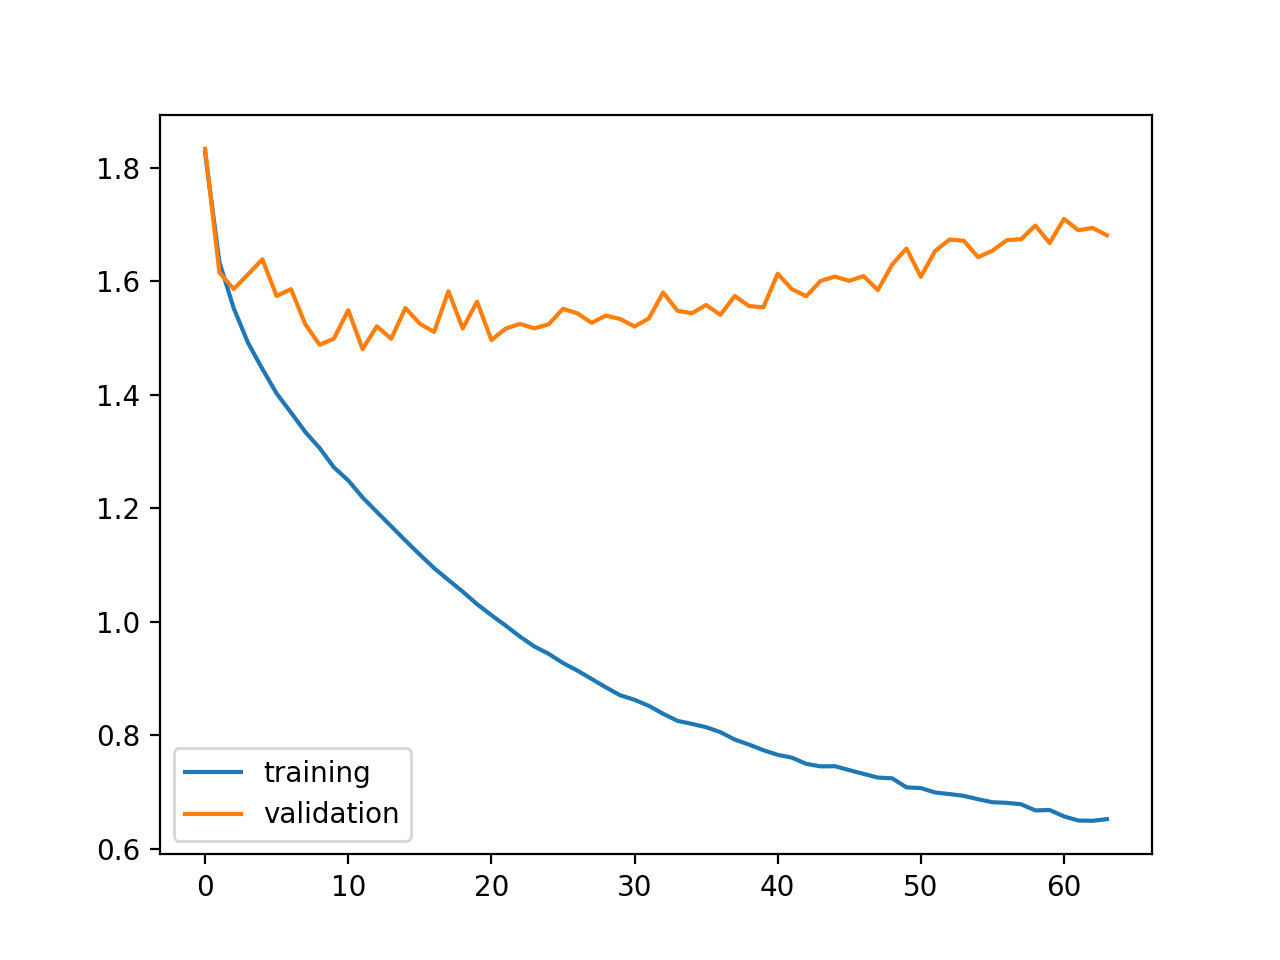

In [41]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


# save loss data

In [64]:
import pickle

In [65]:
with open('../result/loss/model1_cluster9_epoch64', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [66]:
file = open('../result/loss/model1_cluster9_epoch64', 'rb')
data = pickle.load(file)

# model 2 cluster: 5, batch_size = 1024, emb = 32, n_kernels = 128, kernel_width = 3, epoches = 64

In [94]:
batch_size = 1024
n_class = 5
train_dg = DataGenerator(train_df, batch_size=batch_size, shuffle=True, weight=True, n_class = n_class)
val_dg = DataGenerator(val_df, batch_size=batch_size, shuffle=False, weight=False, n_class = n_class)

In [95]:
emb = 32
n_kernels = 128
kernel_width = 3
n_class = 5

In [96]:
model = clf_model(tokenizer, emb, n_kernels, kernel_width, n_class)  # initialize the weights
compile_model(model)  # set the loss fn and optimizer
print(model.summary())  # check the number of parameters
model.save('../result/model/model2_cluster5_epoch64.h5')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     10784       input_5[0][0]                    
__________________________________________________________________________________________________
conv (Conv1D)                   (None, None, 128)    12416       embedding[0][0]                  
__________________________________________________________________________________________________
mask (Mask)                     (None, None)         0           input_5[0][0]                    
__________________________________________________________________________________________________
apply_mask

In [98]:
history = model.fit_generator(
    train_dg,
    validation_data=val_dg,
    epochs=64,
#     workers=5,
#     use_multiprocessing=True
)

Epoch 1/64


/jet/var/python/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


264/264 [==============================] - 22s 83ms/step - loss: 1.3535 - sparse_categorical_accuracy: 0.3594 - val_loss: 1.2333 - val_sparse_categorical_accuracy: 0.4519
Epoch 2/64
264/264 [==============================] - 19s 73ms/step - loss: 1.2116 - sparse_categorical_accuracy: 0.4488 - val_loss: 1.2416 - val_sparse_categorical_accuracy: 0.4451
Epoch 3/64
264/264 [==============================] - 19s 73ms/step - loss: 1.1400 - sparse_categorical_accuracy: 0.4850 - val_loss: 1.1998 - val_sparse_categorical_accuracy: 0.4740
Epoch 4/64
264/264 [==============================] - 19s 73ms/step - loss: 1.0923 - sparse_categorical_accuracy: 0.5074 - val_loss: 1.1605 - val_sparse_categorical_accuracy: 0.4963
Epoch 5/64
264/264 [==============================] - 19s 73ms/step - loss: 1.0525 - sparse_categorical_accuracy: 0.5203 - val_loss: 1.1187 - val_sparse_categorical_accuracy: 0.5180
Epoch 6/64
264/264 [==============================] - 19s 73ms/step - loss: 1.0178 - sparse_categoric

Epoch 46/64
264/264 [==============================] - 19s 73ms/step - loss: 0.4906 - sparse_categorical_accuracy: 0.7190 - val_loss: 1.1403 - val_sparse_categorical_accuracy: 0.5962
Epoch 47/64
264/264 [==============================] - 19s 73ms/step - loss: 0.4729 - sparse_categorical_accuracy: 0.7267 - val_loss: 1.1380 - val_sparse_categorical_accuracy: 0.6003
Epoch 48/64
264/264 [==============================] - 19s 73ms/step - loss: 0.4869 - sparse_categorical_accuracy: 0.7208 - val_loss: 1.1578 - val_sparse_categorical_accuracy: 0.5957
Epoch 49/64
264/264 [==============================] - 20s 75ms/step - loss: 0.4911 - sparse_categorical_accuracy: 0.7175 - val_loss: 1.1547 - val_sparse_categorical_accuracy: 0.6006
Epoch 50/64
264/264 [==============================] - 19s 74ms/step - loss: 0.4606 - sparse_categorical_accuracy: 0.7322 - val_loss: 1.1727 - val_sparse_categorical_accuracy: 0.5900
Epoch 51/64
264/264 [==============================] - 19s 74ms/step - loss: 0.4649 -

In [99]:
with open('../result/loss/model2_cluster5_epoch64', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

<IPython.core.display.Javascript object>


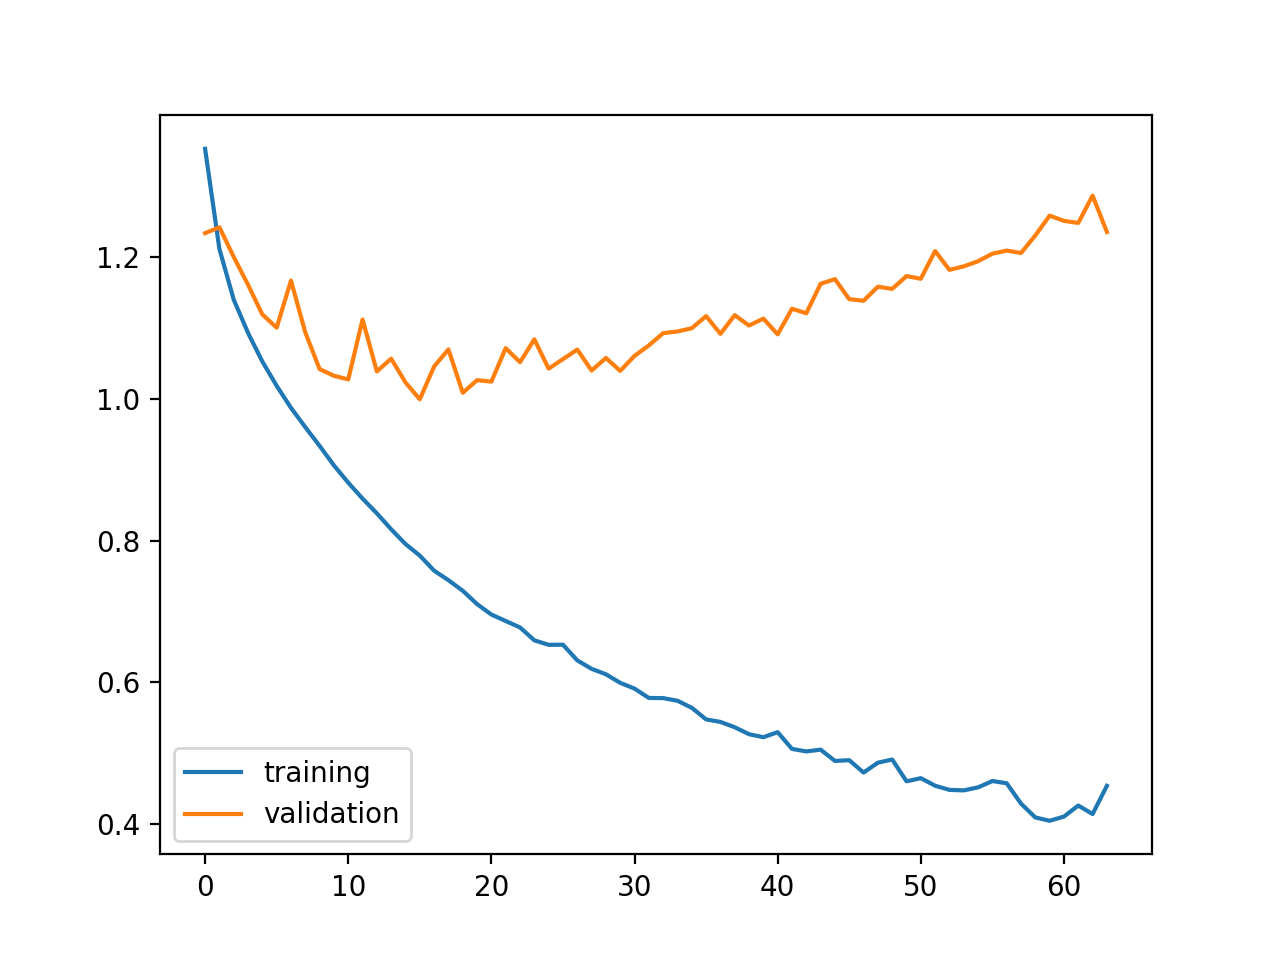

In [100]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Evaluation

## evaluation tools

In [43]:
! pip install sklearn

    100% |████████████████████████████████| 6.7MB 201kB/s eta 0:00:01    42% |█████████████▌                  | 2.8MB 37.2MB/s eta 0:00:01
    100% |████████████████████████████████| 286kB 4.5MB/s eta 0:00:01
  Running setup.py bdist_wheel for sklearn ... done
  Stored in directory: /home/jet/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
You are using pip version 9.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [148]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

%matplotlib notebook

def plot_confusion_matrix(y_true, y_pred, classes, name,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.savefig('../result/confusion_matrix/' + name + '.png')
    return ax

In [108]:
def predict_on_df(model, df, batch_size, n_class):
    dg = DataGenerator(df, batch_size=batch_size, shuffle=False, weight = False, n_class = n_class)
    yhat = model.predict_generator(dg)
    pred_index = yhat.argmax(axis=1)
    pred_conf = yhat.max(axis=1)
    df['pred_index'] = pred_index
    df['pred_label'] = df.pred_index.apply(lambda x: list(label_map.keys())[x])
    df['pred_conf'] = pred_conf
    df['match'] = df['pred_index'] == df['Label']
    return df


def display_top_losses(prediction_df, k: int = 10):
    wrong_condition = ~prediction_df.match
    wrong_df = prediction_df[wrong_condition]
    return wrong_df.sort_values('pred_conf', ascending=False).iloc[0:k][['Equation', 'pred_label', 'Cluster_label', 'pred_index', 'Label', 'pred_conf']]
    
def predict_from_str(equation, model, tokenizer):
    X = np.array([encode_sequence(equation, tokenizer)])
    yhat = model.predict(X)
    pred_index = yhat.argmax()
    label = [label for label, i in label_map.items() if i==pred_index][0]
    return {
        'yhat': yhat.tolist(),
        'pred_index': pred_index,
        'label': label
           }

## evaluate

In [109]:
batch_size = 1024
n_class = 5
predictions = predict_on_df(model, val_df, batch_size, n_class)


In [111]:
name = "model2_cluster5_epoch64"

Confusion matrix, without normalization
[[5200 1076  532  312  323]
 [1107 8020 2598 2090  425]
 [ 180  826 2245  583  116]
 [  79  541  500  990   72]
 [ 121  132   49   35  113]]


<IPython.core.display.Javascript object>


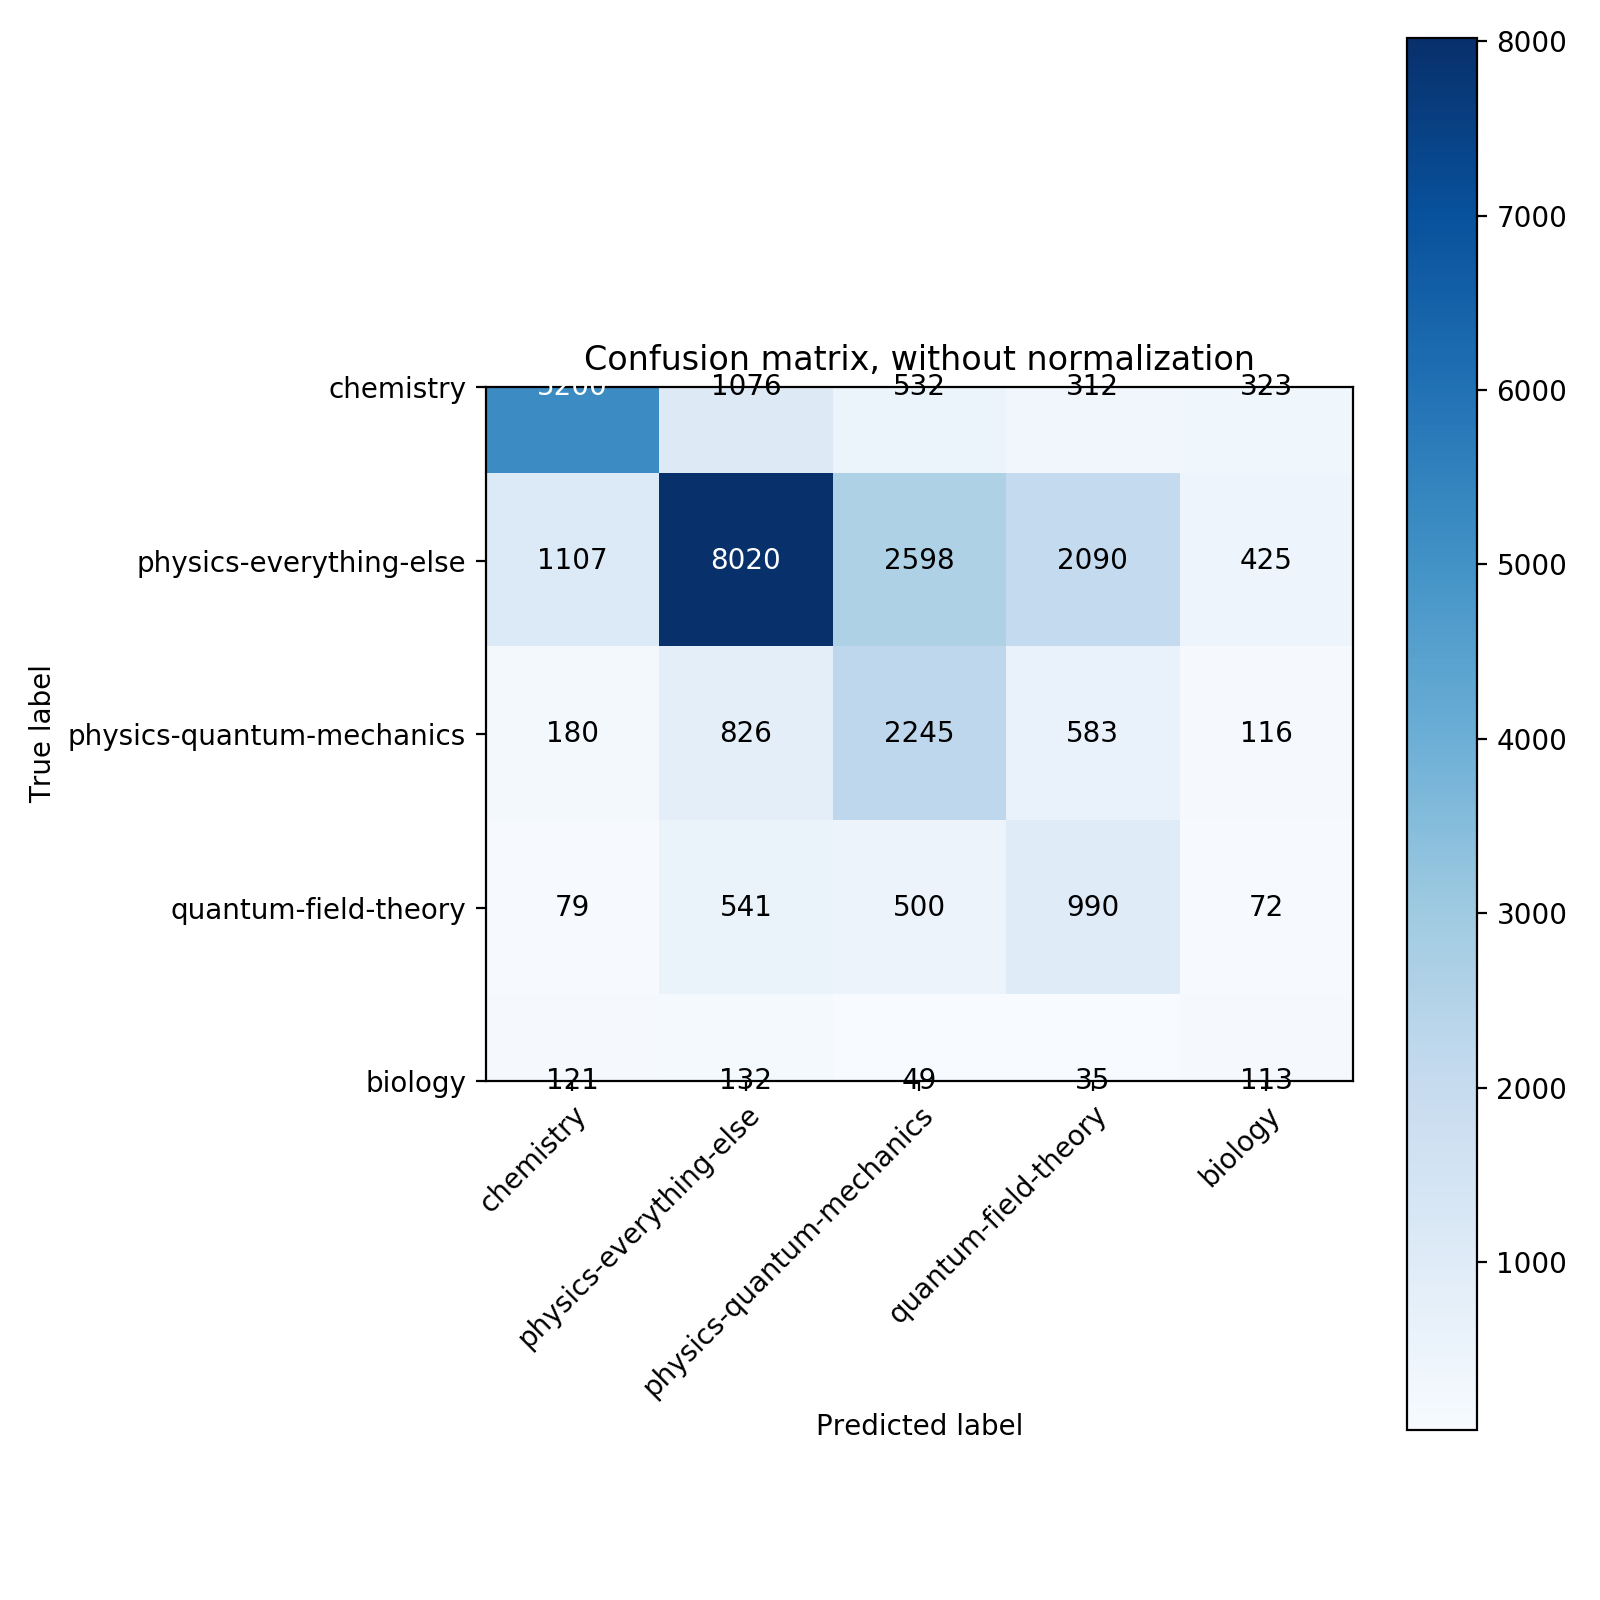

In [149]:
plot_confusion_matrix(predictions.Label, predictions.pred_index, np.array(list(label_map.keys())), name)


In [150]:
predict_from_str('H\PSI = E\PSI', model, tokenizer)

{'label': 'physics-quantum-mechanics',
 'pred_index': 2,
 'yhat': [[0.005024387035518885,
   0.0541561022400856,
   0.9406111240386963,
   0.0001076638072845526,
   0.0001006694437819533]]}

In [151]:
display_top_losses(predictions, 100)

,Equation,pred_label,Cluster_label,pred_index,Label,pred_conf
46515,kg\hspace{1mm}H_2SO_4,biology,chemistry,4,0,1.000000
551926,F_{2NET},biology,physics-everything-else,4,1,0.999999
157952,Cl^- + 3H_2O = ClO_3^- + 6e^- + 6H^+,biology,chemistry,4,0,0.999998
447126,E[XY]=E[X]E[Y],biology,physics-quantum-mechanics,4,2,0.999997
122502,v_r = \frac{2Z^*}{N_A} \cdot 10^3\ \ \ \left(\...,biology,chemistry,4,0,0.999994
510915,μ mol\: O_{2}\cdot cm^{-2}\cdot\mu m\cdot kPa^...,biology,physics-everything-else,4,1,0.999994
96456,X_s =0.08,biology,chemistry,4,0,0.999992
273114,"10,000? \",biology,physics-everything-else,4,1,0.999992
563437,n = \log_2(N=8) = 3,biology,physics-everything-else,4,1,0.999987
645144,"12 \,\ce{H_2O}-6\,\ce{H_2O}",chemistry,biology,0,4,0.999984
